In [202]:
import json
import pandas as pd
import numpy as np

# Load Python libraries
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import text
from sklearn.linear_model import LogisticRegression
import sklearn.model_selection as modsel
import sklearn.preprocessing as preproc
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [204]:
biz_f = open('C:\\Users\\Faycal\\Downloads\\yelp-dataset\\yelp_academic_dataset_business.json', encoding='utf8')
biz_df = pd.DataFrame([json.loads(x) for x in biz_f.readlines()])
biz_f.close()

In [205]:
review_file = open('C:\\Users\\Faycal\\Downloads\\yelp-dataset\\yelp_academic_dataset_review.json', encoding='utf8')
review_df = pd.DataFrame([json.loads(x) for x in review_file.readlines()])
review_file.close()

In [206]:
for i in biz_df.select_dtypes(include=['object']).columns:
    biz_df[i][biz_df[i].isnull()] = 'unknown'
biz_df = biz_df.fillna(value=0)


In [207]:
two_biz = biz_df[biz_df.apply(lambda x: 'Nightlife' in x['categories'] 
                                        or 'Restaurants' in x['categories'], 
                              axis=1)]

In [208]:
two_biz.shape

(63904, 14)

In [209]:
biz_df.shape

(192609, 14)

In [210]:
twobiz_reviews = two_biz.merge(review_df, on='business_id', how='inner')

In [211]:
twobiz_reviews.shape

(4394352, 22)

In [212]:
twobiz_reviews.columns

Index(['address', 'attributes', 'business_id', 'categories', 'city', 'hours',
       'is_open', 'latitude', 'longitude', 'name', 'postal_code',
       'review_count', 'stars_x', 'state', 'cool', 'date', 'funny',
       'review_id', 'stars_y', 'text', 'useful', 'user_id'],
      dtype='object')

In [213]:
twobiz_reviews = twobiz_reviews[['business_id', 
                                 'name', 
                                 'stars_y', 
                                 'text', 
                                 'categories']]

In [214]:
two_biz_reviews.columns

Index(['business_id', 'name', 'stars_y', 'text', 'categories'], dtype='object')

In [215]:
nightlife = twobiz_reviews[twobiz_reviews.apply(lambda x: 'Nightlife' in x['categories'], axis=1)]
restaurants = twobiz_reviews[twobiz_reviews.apply(lambda x: 'Restaurants' in x['categories'], axis=1)]

In [218]:
nightlife.shape

(1202166, 5)

In [219]:
restaurants.shape

(4201684, 5)

In [220]:
restaurants.head()

,business_id,name,stars_y,text,categories
0,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,3.0,My girlfriend and I went for dinner at Emerald...,"Specialty Food, Restaurants, Dim Sum, Imported..."
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,3.0,We've always been there on a Sunday so we were...,"Specialty Food, Restaurants, Dim Sum, Imported..."
2,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,3.0,"***No automatic doors, not baby friendly!*** I...","Specialty Food, Restaurants, Dim Sum, Imported..."
3,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,1.0,"Horrible service,\nI went there tonight with m...","Specialty Food, Restaurants, Dim Sum, Imported..."
4,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,4.0,One of the gauges of a good Chinese restaurant...,"Specialty Food, Restaurants, Dim Sum, Imported..."


Scalling Nightlife and restaurant subset to avoid Class Imbalanced 

In [221]:
nightlife_subset = nightlife.sample(frac=0.1, random_state=123)

In [222]:
nightlife_subset.shape

(120217, 5)

In [268]:
1202166/4201684

0.2861152813966971

In [228]:
restaurant_subset = restaurants.sample(frac=0.2861152813966971, random_state=1)

In [230]:
restaurant_subset = restaurant_subset.sample(frac=0.1, random_state=1)

In [231]:
restaurant_subset.shape

(120217, 5)

In [232]:
combined = pd.concat([nightlife_subset, restaurant_subset])

In [233]:
combined['target'] = combined.apply(lambda x: 'Nightlife' in x['categories'],
                                    axis=1)

In [234]:
# Split into training and test data sets
training_data, test_data = train_test_split(combined, 
                                                   train_size=0.7, 
                                                   random_state=123)

In [235]:
training_data.shape

(168303, 6)

In [236]:
test_data.shape

(72131, 6)

# Represent the review text as a bag-of-words 

In [237]:
bow_transform = text.CountVectorizer()

In [238]:
X_tr_bow = bow_transform.fit_transform(training_data['text'])
X_te_bow = bow_transform.transform(test_data['text'])

In [239]:
len(bow_transform.vocabulary_)

94771

In [240]:
X_tr_bow.shape

(168303, 94771)

In [283]:
bow_transform.vocabulary_['like']

49114

In [242]:
y_tr = training_data['target']
y_te = test_data['target']

# Create the tf-idf representation using the bag-of-words matrix

In [243]:
tfidf_trfm = text.TfidfTransformer(norm=None)
X_tr_tfidf = tfidf_trfm.fit_transform(X_tr_bow)

In [244]:
X_te_tfidf = tfidf_trfm.transform(X_te_bow)

# l2 Normalize the Bag of Word representation

In [245]:
X_tr_l2 = preproc.normalize(X_tr_bow, axis=0)
X_te_l2 = preproc.normalize(X_te_bow, axis=0)

# Classification with logistic regression


In [246]:
def simple_logistic_classify(X_tr, y_tr, X_test, y_test, description, _C=1.0):
    ## Helper function to train a logistic classifier and score on test data
    m = LogisticRegression(C=_C).fit(X_tr, y_tr)
    s = m.score(X_test, y_test)
    print ('Test score with', description, 'features:', s)
    return m

In [247]:
m1 = simple_logistic_classify(X_tr_bow, y_tr, X_te_bow, y_te, 'bow')
m2 = simple_logistic_classify(X_tr_l2, y_tr, X_te_l2, y_te, 'l2-normalized')
m3 = simple_logistic_classify(X_tr_tfidf, y_tr, X_te_tfidf, y_te, 'tf-idf')

Test score with bow features: 0.7676865702679846
Test score with l2-normalized features: 0.7357724140799379
Test score with tf-idf features: 0.7453799337316827


# Tune regularization parameters using grid search

In [248]:
param_grid_ = {'C': [1e-5, 1e-3, 1e-1, 1e0, 1e1, 1e2]}
bow_search = modsel.GridSearchCV(LogisticRegression(), cv=5, param_grid=param_grid_)
l2_search = modsel.GridSearchCV(LogisticRegression(), cv=5,
                               param_grid=param_grid_)
tfidf_search = modsel.GridSearchCV(LogisticRegression(), cv=5,
                                   param_grid=param_grid_)

In [249]:
bow_search.fit(X_tr_bow, y_tr)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1e-05, 0.001, 0.1, 1.0, 10.0, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [250]:
bow_search.best_score_

0.770425957944897

In [256]:
bow_search.best_params_

{'C': 0.1}

In [251]:
l2_search.fit(X_tr_l2, y_tr)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1e-05, 0.001, 0.1, 1.0, 10.0, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [261]:
l2_search.best_score_

0.7606281527958504

In [253]:
l2_search.best_params_

{'C': 10.0}

In [255]:
tfidf_search.fit(X_tr_tfidf, y_tr)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1e-05, 0.001, 0.1, 1.0, 10.0, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [258]:
tfidf_search.best_score_

0.772980873781216

In [259]:
tfidf_search.best_params_

{'C': 0.001}

In [262]:
bow_search.cv_results_

{'mean_fit_time': array([  1.38230214,   3.7719099 ,  31.42324433, 114.53162909,
        134.40327296, 127.89707689]),
 'std_fit_time': array([ 0.0518497 ,  0.11125161,  4.23107531, 15.33255227, 27.85298832,
        28.82388462]),
 'mean_score_time': array([0.01655579, 0.0141624 , 0.01456118, 0.01396298, 0.01436148,
        0.01436148]),
 'std_score_time': array([0.00421268, 0.00039895, 0.00119662, 0.00063075, 0.00048864,
        0.00048864]),
 'param_C': masked_array(data=[1e-05, 0.001, 0.1, 1.0, 10.0, 100.0],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1e-05},
  {'C': 0.001},
  {'C': 0.1},
  {'C': 1.0},
  {'C': 10.0},
  {'C': 100.0}],
 'split0_test_score': array([0.62370031, 0.7489454 , 0.77339433, 0.76685877, 0.76427426,
        0.7673935 ]),
 'split1_test_score': array([0.62377826, 0.74941327, 0.77169425, 0.76619827, 0.75351297,
        0.75395859]),
 'split2_test_score': array([0.62418301, 0.7

In [263]:
search_results = pd.DataFrame.from_dict({'bow': bow_search.cv_results_['mean_test_score'],
                               'tfidf': tfidf_search.cv_results_['mean_test_score'],
                               'l2': l2_search.cv_results_['mean_test_score']})
search_results

,bow,tfidf,l2
0,0.623934,0.740813,0.621302
1,0.747568,0.772981,0.621302
2,0.770426,0.747414,0.621950
3,0.763944,0.738567,0.693927
4,0.754811,0.736897,0.760628
5,0.753795,0.735911,0.750236


# Cross validation results

In [264]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

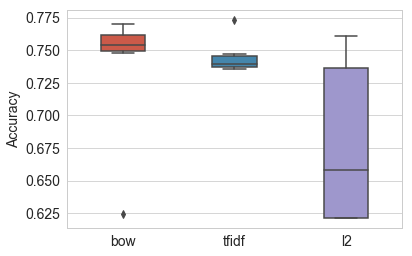

In [265]:
ax = sns.boxplot(data=search_results, width=0.4)
ax.set_ylabel('Accuracy', size=14)
ax.tick_params(labelsize=14)
plt.savefig('tfidf_gridcv_results.png')

# Best Hyperparameter

In [266]:
m1 = simple_logistic_classify(X_tr_bow, y_tr, X_te_bow, y_te, 'bow', 
                              _C=bow_search.best_params_['C'])
m2 = simple_logistic_classify(X_tr_l2, y_tr, X_te_l2, y_te, 'l2-normalized', 
                              _C=l2_search.best_params_['C'])
m3 = simple_logistic_classify(X_tr_tfidf, y_tr, X_te_tfidf, y_te, 'tf-idf', 
                              _C=tfidf_search.best_params_['C'])

Test score with bow features: 0.7721506703081893
Test score with l2-normalized features: 0.7681163438743397
Test score with tf-idf features: 0.7748818122582524


In [267]:
bow_search.cv_results_['mean_test_score']

array([0.62393421, 0.74756837, 0.77042596, 0.7639436 , 0.75481126,
       0.75379524])